<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/01b_model_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [1]:
#!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [1]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Model API

This tutorial introduces the SeisBench model API. It explains how to load pretrained models and apply them to generate characteristic curves or discrete picks.

**Note:** Some familiarity with obspy is helpful for this tutorial, but not required.

In [2]:
import seisbench
import seisbench.models as sbm

### Creating a model

SeisBench models are built in pytorch. They can simply be created by intiatiating an object of the desired class.
Let's first create a simple GPD model. As we see in the output, the model consists of a set of convolutional layers and linear layers. Furthermore, the model indicates that it expects data with ZNE component order

In [3]:
model = sbm.PhaseNet()
print(model)

Component order:	ZNE
SeisBench model		PhaseNet

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
  (in_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1dSame(
    (conv): Conv1d(8, 11, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1dSame(
    (conv): Conv1d(11, 16, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1dSame(
    (conv): Conv1d(16, 22, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd3): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1dSame(
    (conv): Conv1d(22, 32, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up1): ConvTranspose1d(32, 22, kernel_size

As pytorch model, the model can be applied to pytorch tensors.

In [4]:
import torch

x = torch.rand(1, 3, 3001)  # 1 example, 3 components, 400 samples
model.eval()
with torch.no_grad():
    print(model(x))
x

tensor([[[0.4733, 0.4653, 0.4701,  ..., 0.4614, 0.4801, 0.4779],
         [0.3054, 0.3123, 0.3049,  ..., 0.3022, 0.3012, 0.2969],
         [0.2213, 0.2224, 0.2250,  ..., 0.2365, 0.2187, 0.2252]]])


tensor([[[4.5001e-02, 4.9129e-01, 7.2390e-01,  ..., 3.7653e-01,
          2.5591e-01, 1.2714e-02],
         [7.9809e-01, 4.7492e-01, 4.9021e-01,  ..., 3.2449e-04,
          8.2614e-01, 5.3133e-01],
         [4.2542e-01, 5.5224e-01, 3.6837e-01,  ..., 3.2581e-01,
          2.1591e-01, 9.2882e-01]]])

### Loading pretrained models

The model created above consisted of random weights, i.e., it was not trained. While this is (often) the right approach when starting to train a model, for application we'll need a trained model. SeisBench offers pretrained models, which can be loaded with the `from_pretrained` method. To list available pretrained models, we can use `list_pretrained`. By setting `details=True`, we also get a docstring for each model.

In [5]:
pretrained_weights = sbm.PhaseNet.list_pretrained(details=True)
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

ethz:
Model trained on ETHZ for 100 epochs with a learning rate of 0.01.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)
-----------------------

geofon:
Model trained on GEOFON for 100 epochs with a learning rate of 0.01.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)
-----------------------

instance:
Model trained on INSTANCE for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-

We are going to load the model from Ross et al. (2018) that was trained on examples from Southern California. If the model is loaded for the first time, it will be downloaded from the SeisBench repository. The downloaded model is cached in the SeisBench cache. Pretrained models also have docstrings, describing the model.

In [7]:
model = sbm.PhaseNet.from_pretrained("instance")
print(model.weights_docstring)

Model trained on INSTANCE for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)


\### Annotating waveform streams

SeisBench models can directly annotate obspy streams. Let's download a 200 s long piece of waveforms from a station in Chile through FDSN and visualize it.

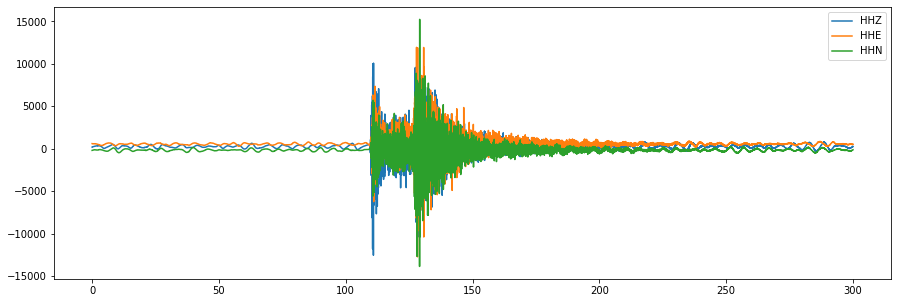

In [7]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt

client = Client("GFZ")

t = UTCDateTime("2007/01/02 05:48:50")
stream = client.get_waveforms(network="CX", station="PB01", location="*", channel="HH?", starttime=t-100, endtime=t+200)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

SeisBench models can generate characteristic curves, i.e., curves providing the probability of a pick at a certain time. For this, the annotate function is used. Annotate automatically transforms the trace into a compatible format for the model and merges the preditions into traces. For example, annotate will determine the correct component order and resample the trace to the required sampling rate.

In [8]:
annotations = model.annotate(stream)
print(annotations)

3 Trace(s) in Stream:
CX.PB01..PhaseNet_N | 2007-01-02T05:47:09.998392Z - 2007-01-02T05:52:09.998392Z | 100.0 Hz, 30001 samples
CX.PB01..PhaseNet_P | 2007-01-02T05:47:09.998392Z - 2007-01-02T05:52:09.998392Z | 100.0 Hz, 30001 samples
CX.PB01..PhaseNet_S | 2007-01-02T05:47:09.998392Z - 2007-01-02T05:52:09.998392Z | 100.0 Hz, 30001 samples


`annotate` takes additional, optional arguments that depend on the specific model and are documented in the model defintion. For example, GPD is applied with a sliding window approach and therefore has a `stride` parameter, indicating the distance between two consequtive applications of the model. Let's try out a different stride.

In [10]:
annotations = model.annotate(stream, stride=5)
print(annotations)

3 Trace(s) in Stream:
CX.PB01..PhaseNet_P | 2007-01-02T05:47:09.998392Z - 2007-01-02T05:52:09.998392Z | 100.0 Hz, 30001 samples
CX.PB01..PhaseNet_S | 2007-01-02T05:47:09.998392Z - 2007-01-02T05:52:09.998392Z | 100.0 Hz, 30001 samples
CX.PB01..PhaseNet_N | 2007-01-02T05:47:09.998392Z - 2007-01-02T05:52:09.998392Z | 100.0 Hz, 30001 samples


As you see, the predictions now come with a sampling rate of 20 Hz instead of 10 Hz. You might have also noticed that the annotation process took a bit longer, because GPD was applied twice as often.

Let's visualize the predictions alongside the waveforms. As we can see, GPD correctly identified the P and S arrival of the main event. There are multiple further detections, mostly with lower confidence. This is common for GPD, which should always be used with a fairly high threshold for defining a detection.

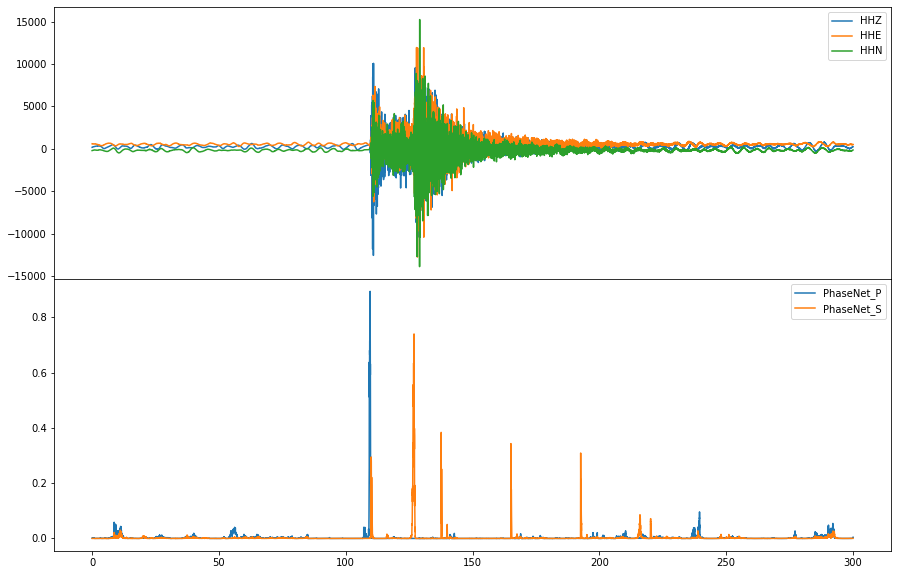

In [11]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In addition to the `annotate` function, SeisBench models offer the `classify` function. This function returns discrete objects, in this case, picks. Again, we can pass configuration parameters to the function. Here, we provide detection thresholds.

In [12]:
picks = model.classify(stream, P_threshold=0.95, S_threshold=0.95)
print("Picks:")
for pick in picks:
    print(pick)

Picks:


### Model interchangability

The standardized model API makes it easy to use a different model. Let's try out EQTransformer. For this, we use the pretrained weights from Mousavi et al. (2020). Note that in addition to picks, EQTransformer returns detections.

In [13]:
model = sbm.EQTransformer.from_pretrained("original")
print(model.weights_docstring)

Original EQTransformer model from Mousavi et al. (2020). Originally published under MIT License. Original available at https://github.com/smousavi05/EQTransformer/blob/906075feb8aaa61030ed6de1b02a6f749ef103a0/ModelsAndSampleData/EqT_model.h5 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@gfz-potsdam.de)


3 Trace(s) in Stream:
CX.PB01..EQTransformer_Detection | 2007-01-02T05:47:14.998392Z - 2007-01-02T05:52:04.998392Z | 100.0 Hz, 29001 samples
CX.PB01..EQTransformer_P         | 2007-01-02T05:47:14.998392Z - 2007-01-02T05:52:04.998392Z | 100.0 Hz, 29001 samples
CX.PB01..EQTransformer_S         | 2007-01-02T05:47:14.998392Z - 2007-01-02T05:52:04.998392Z | 100.0 Hz, 29001 samples


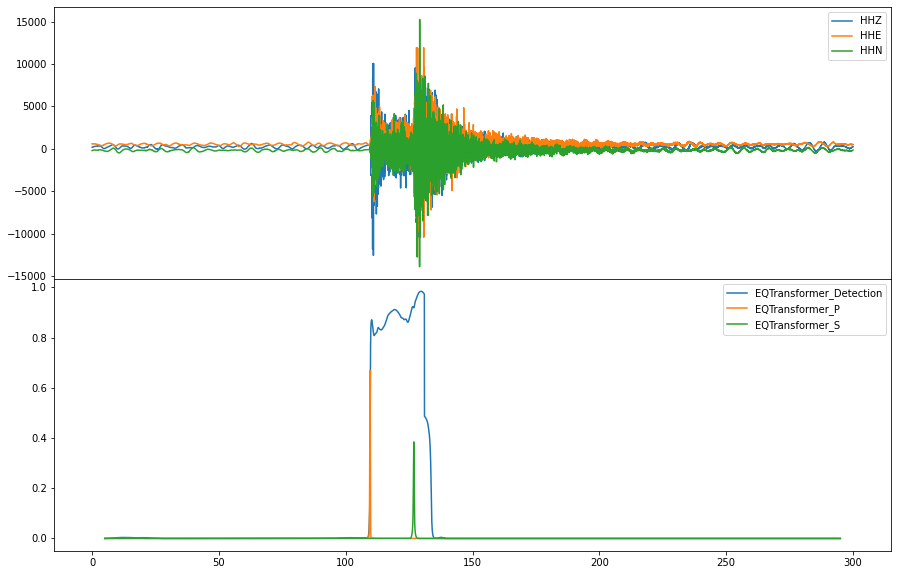

In [14]:
annotations = model.annotate(stream)
print(annotations)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [15]:
picks, detections = model.classify(stream)
print("Picks:")
for pick in picks:
    print(pick)

print("\nDetections:")    
for detection in detections:
    print(detection)

Picks:
CX.PB01.	2007-01-02T05:48:59.588392Z	P
CX.PB01.	2007-01-02T05:49:16.818392Z	S

Detections:
CX.PB01.	2007-01-02T05:48:59.568392Z	2007-01-02T05:49:23.738392Z


### Batch processing

Processing is not limited to a single station, but can be applied to streams from different stations. SeisBench will automatically convert the traces into the correct tensors and the annotations back to streams. For more efficient processing, let's first move the model to GPU. Moving a model to GPU will automatically process the computations of `annotate` and `classify` on GPU.

**Note:** This command will fail, if you do not have a properly configured GPU. In this case, just skip it.

In [16]:
model.cuda();

Now let's download the same time window as above, but for all stations in the CX network and generate the picks and detections with EQTransformer.

In [17]:
stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t-100, endtime=t+100)

picks, detections = model.classify(stream)
print("Picks:")
for pick in picks:
    print(pick)

print("\nDetections:")    
for detection in detections:
    print(detection)

Picks:
CX.PB01.	2007-01-02T05:48:59.588392Z	P
CX.PB01.	2007-01-02T05:49:16.818392Z	S
CX.PB02.	2007-01-02T05:49:03.558392Z	P
CX.PB02.	2007-01-02T05:49:23.008392Z	S
CX.PB03.	2007-01-02T05:49:05.458392Z	P
CX.PB03.	2007-01-02T05:49:26.188392Z	S
CX.PB04.	2007-01-02T05:49:20.998392Z	P
CX.PB04.	2007-01-02T05:49:35.278392Z	S
CX.PB05.	2007-01-02T05:49:43.048392Z	S

Detections:
CX.PB01.	2007-01-02T05:48:59.568392Z	2007-01-02T05:49:23.738392Z
CX.PB02.	2007-01-02T05:49:03.678392Z	2007-01-02T05:49:28.988392Z
CX.PB03.	2007-01-02T05:49:20.998392Z	2007-01-02T05:49:29.218392Z
CX.PB04.	2007-01-02T05:49:21.068392Z	2007-01-02T05:49:41.238392Z
CX.PB05.	2007-01-02T05:49:26.278392Z	2007-01-02T05:49:50.308392Z


This concludes the model API tutorial. Check out the other SeisBench tutorials to get to know the other functionalities.